In [1]:
import re
import sys
import os
from tempfile import TemporaryDirectory
import numpy as np
import pandas as pd 

from collections import defaultdict
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.utils.timer import Timer
from recommenders.datasets.amazon_reviews import get_review_data
from recommenders.datasets.split_utils import filter_k_core

# Transformer Based Models
from recommenders.models.sasrec.model import SASREC
from recommenders.models.sasrec.ssept import SSEPT

# Sampler for sequential prediction
from recommenders.models.sasrec.sampler import WarpSampler
from recommenders.models.sasrec.util import SASRecDataSet

import matplotlib.pyplot as plt
# custom split from train / test / validation
from collections import defaultdict
import random
from tqdm import tqdm
import numpy as np
import random
from tqdm import tqdm
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

print("System version: {}".format(sys.version))
print("Tensorflow version: {}".format(tf.__version__))

System version: 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) 
[Clang 14.0.6 ]
Tensorflow version: 2.11.0


In [2]:
batch_size = 128
RANDOM_SEED = 100  # Set None for non-deterministic result

lr = 0.001             # learning rate
maxlen = 50            # maximum sequence length for each user
num_blocks = 2         # number of transformer blocks
hidden_units = 100     # number of units in the attention calculation
num_heads = 1          # number of attention heads
dropout_rate = 0.1     # dropout rate
l2_emb = 0.0           # L2 regularization coefficient
num_neg_test = 100     # number of negative examples per positive example
model_name = 'sasrec'  # 'sasrec' or 'ssept'

In [3]:
def load(dataset_name):
    # read raw data
    train = pd.read_csv('../data/{}/train.csv'.format(dataset_name))
    test  = pd.read_csv('../data/{}/test.csv'.format(dataset_name))

    # sort by time, save the temporary version
    train = train.sort_values(['userID', 'timestamp'])
    test = test.sort_values(['userID', 'timestamp'])

    train[['userID', 'itemID']].to_csv('../data/{}/train_tmp.csv'.format(dataset_name), index=False, header=False)
    test[['userID', 'itemID']].to_csv('../data/{}/test_tmp.csv'.format(dataset_name), index=False, header=False)

    return train, test

<h1>Custom data feeder</h1>

In [4]:
def data_partition(self, filename_train, filename_test):
    # assume user/item index starting from 1
    f = open(filename_train, "r")
    for line in f:
        u, i = line.rstrip().split(self.col_sep)
        u = int(u)
        i = int(i)
        self.usernum = max(u, self.usernum)
        self.itemnum = max(i, self.itemnum)
        self.User[u].append(i)

    for user in self.User:
        nfeedback = len(self.User[user])
        if nfeedback < 2:
            self.user_train[user] = self.User[user]
            self.user_valid[user] = []
            self.user_test[user] = []
        else:
            self.user_train[user] = self.User[user][:-1]
            self.user_valid[user] = []
            self.user_valid[user].append(self.User[user][-1])
            self.user_test[user] = []

    User_test = defaultdict(list)
    f = open(filename_test, "r")
    for line in f:
        u, i = line.rstrip().split(self.col_sep)
        u = int(u)
        i = int(i)
        User_test[u].append(i)

    for user in User_test:
        self.user_test[user] = User_test[user][:]

<h1>Model definition</h1>

In [5]:
def init_SASREC(data):
    model = SASREC(item_num=data.itemnum,
        seq_max_len=maxlen,
        num_blocks=num_blocks,
        embedding_dim=hidden_units,
        attention_dim=hidden_units,
        attention_num_heads=num_heads,
        dropout_rate=dropout_rate,
        conv_dims = [100, 100],
        l2_reg=l2_emb,
        num_neg_test=data.itemnum-1#num_neg_test
    )
    return model

In [15]:
def predict(self, dataset, num_workers=16):
    from concurrent.futures import ThreadPoolExecutor
    import concurrent

    usernum = dataset.usernum
    itemnum = dataset.itemnum
    train = dataset.user_train
    valid = dataset.user_valid
    test = dataset.user_test

    if usernum > 10000:
        users = random.sample(range(1, usernum + 1), 20000)
    else:
        users = range(1, usernum + 1)

    def predict_user(u):
        # not enough training data
        if len(train[u]) < 1 or len(test[u]) < 1:
            return None

        # construct user purchase history
        seq = np.zeros([self.seq_max_len], dtype=np.int32)
        idx = self.seq_max_len - 1
        seq[idx] = valid[u][0]
        idx -= 1
        for i in reversed(train[u]):
            seq[idx] = i
            idx -= 1
            if idx == -1:
                break

        # already interacted items
        rated = set(train[u])

        item_idx = np.arange(itemnum)

        inputs = {}
        inputs["user"] = np.expand_dims(np.array([u]), axis=-1)
        inputs["input_seq"] = np.array([seq])
        inputs["candidate"] = np.array([item_idx])

        # inverse to get descending sort
        predictions = -1.0 * self.predict(inputs)
        predictions = np.array(predictions)
        predictions = predictions[0]

        return u, {'predictions': predictions, 'test': test[u]}

    results = {}

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        future_to_user = {executor.submit(predict_user, u): u for u in users}
        for future in tqdm(concurrent.futures.as_completed(future_to_user), total=len(users), ncols=70, leave=False, unit="b"):
            user_result = future.result()
            if user_result is not None:
                u, res = user_result
                results[u] = res

    return results


In [28]:
class SASREC_recsys:
    def __init__(self, name):
        
        self.train, self.test = load(name)

        # initiate a dataset class 
        self.data = SASRecDataSet(filename='../data/{}/train_tmp.csv'.format(name), col_sep=",")
        # split the dataset
        data_partition(self.data, '../data/{}/train_tmp.csv'.format(name), '../data/{}/test_tmp.csv'.format(name))

        # sampler
        self.sampler = WarpSampler(self.data.user_train, self.data.usernum, self.data.itemnum, batch_size=batch_size, maxlen=maxlen, n_workers=8)

        self.model = init_SASREC(self.data)

    def fit(self):
        with Timer() as train_time:
            _ = self.model.train(self.data, self.sampler, num_epochs=10, batch_size=batch_size, lr=lr, val_epoch=1000)

        print('Time cost for training is {0:.2f} mins'.format(train_time.interval/60.0))

    def inference(self):
        TOP_K = 100
        # make predictions
        pred = predict(self.model, self.data)

        # Convert predictions to dataframe df_pred
        items_predicted = []
        score_predicted = []
        user_ids = []
        for u,v in pred.items():
            #
            i_pred = v['predictions'].argsort()[:TOP_K]
            s_pred = -1 * v['predictions'][i_pred]

            items_predicted.extend(list(i_pred))
            score_predicted.extend(list(s_pred))
            user_ids.extend(list(np.full(TOP_K, u)))

        # convert to dataframe
        df_pred = pd.DataFrame({'userID': user_ids, 'itemID': items_predicted, 'prediction': score_predicted})
        print("Prediction shape:", df_pred.shape)

        ##########
        # Extract df_test dataframe
        user_ids = []
        test_ids = []
        for u,v in pred.items():
            test_ids.extend(list(v['test']))
            user_ids.extend(list(np.full(len(v['test']), u)))

        df_test = pd.DataFrame({'userID': user_ids, 'itemID': test_ids})
        df_test['rating'] = 1.0

        print('Testing shape:', df_test.shape)

        return df_pred, df_test
    
    def exclude_seen_pred(self, df_pred):

        # from predicted dataset exclude seen items
        merged = pd.merge(self.train, df_pred, on=["userID", "itemID"], how="outer")
        merged_pred = merged[merged.rating.isnull()].drop('rating', axis=1)

        return merged_pred
    
    def exclude_seen_test(self, df_test):
        # from ground truth test dataset, exclude seen items
        merged = pd.merge(self.train, df_test, on=["userID", "itemID"], how="outer")
        merged_test = merged[merged.rating_x.isnull()].drop('rating_x', axis=1).rename(columns={'rating_y': 'rating'})

        return merged_test
    
    ##########################################
    def map_k(self, data_true, data_pred, K):
        return map_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                    col_rating="rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)
    
    def ndcg_k(self, data_true, data_pred, K):
        return ndcg_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                    col_rating="rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)
    
    def precision_k(self, data_true, data_pred, K):
        return precision_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                    col_rating="rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)
    
    def recall_k(self, data_true, data_pred, K):
        return recall_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                    col_rating="rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)
    

    def get_all_scores(self):
        # predict
        pred, test = self.inference()
        # exlcude train
        pred_exc = self.exclude_seen_pred(pred)
        test_exc = self.exclude_seen_test(test)

        test_df, top_ex = test_exc, pred_exc
        exc_seen_rank = pd.DataFrame({
            'TOP_K': [5, 10, 50],
            'MAP': [self.map_k(test_df, top_ex, 5), self.map_k(test_df, top_ex, 10), self.map_k(test_df, top_ex, 50)],
            'NDCG': [self.ndcg_k(test_df, top_ex, 5), self.ndcg_k(test_df, top_ex, 10), self.ndcg_k(test_df, top_ex, 50)],
            'Precision': [self.precision_k(test_df, top_ex, 5), self.precision_k(test_df, top_ex, 10), self.precision_k(test_df, top_ex, 50)],
            'Recall': [self.recall_k(test_df, top_ex, 5), self.recall_k(test_df, top_ex, 10), self.recall_k(test_df, top_ex, 50)],
        })

        test_df, top_k_df = test, pred
        inc_seen_rank = pd.DataFrame({
            'TOP_K': [5, 10, 50],
            'MAP': [self.map_k(test_df, top_k_df, 5), self.map_k(test_df, top_k_df, 10), self.map_k(test_df, top_k_df, 50)],
            'NDCG': [self.ndcg_k(test_df, top_k_df, 5), self.ndcg_k(test_df, top_k_df, 10), self.ndcg_k(test_df, top_k_df, 50)],
            'Precision': [self.precision_k(test_df, top_k_df, 5), self.precision_k(test_df, top_k_df, 10), self.precision_k(test_df, top_k_df, 50)],
            'Recall': [self.recall_k(test_df, top_k_df, 5), self.recall_k(test_df, top_k_df, 10), self.recall_k(test_df, top_k_df, 50)],
        })

        return exc_seen_rank, inc_seen_rank

In [29]:
def full_train(ds_name):
    recsys = SASREC_recsys(ds_name)
    recsys.fit()
    return recsys.get_all_scores()

In [30]:
exc_seen_rank, inc_seen_rank = full_train('sas')

Epoch: 1 Train Loss: 1.0028718


Epoch: 2 Train Loss: 0.74376


Epoch: 3 Train Loss: 0.6339326


Epoch: 4 Train Loss: 0.5617886


Epoch: 5 Train Loss: 0.5099484


Epoch: 6 Train Loss: 0.47132114


Epoch: 7 Train Loss: 0.43809146


Epoch: 8 Train Loss: 0.41070312


Epoch: 9 Train Loss: 0.3864659


Epoch: 10 Train Loss: 0.36789855
Time cost for training is 4.09 mins


Prediction shape: (831500, 3)
Testing shape: (18574, 3)


In [31]:
exc_seen_rank.style.hide_index()

/var/folders/p5/jqpndw0d2cg7g0mst1n0c49r0000gn/T/ipykernel_53071/3256864183.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  exc_seen_rank.style.hide_index()


TOP_K,MAP,NDCG,Precision,Recall
5,0.078012,0.103762,0.047054,0.131140
10,0.087442,0.123713,0.034842,0.187513
50,0.098070,0.168240,0.014011,0.357601


In [32]:
inc_seen_rank.style.hide_index()

/var/folders/p5/jqpndw0d2cg7g0mst1n0c49r0000gn/T/ipykernel_53071/1931737838.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  inc_seen_rank.style.hide_index()


TOP_K,MAP,NDCG,Precision,Recall
5,0.109183,0.147078,0.065977,0.188638
10,0.120883,0.170874,0.048587,0.257138
50,0.134010,0.221311,0.019105,0.441678


<h3>SAS RFM</h3>

In [22]:
rfm = pd.read_parquet('../data/sas/mart/rfm_mapped.parquet')
rfm_levels = ["Can't Loose Them", "Champions", "Loyal", "Potential", "Sleeping", "Require Activation"]

In [23]:
recsys = SASREC_recsys('sas')
recsys.fit()
# predict
pred, test = recsys.inference()
# exlcude train
pred_exc = recsys.exclude_seen_pred(pred)
test_exc = recsys.exclude_seen_test(test)

Epoch: 1 Train Loss: 1.0061274


Epoch: 2 Train Loss: 0.74273556


Epoch: 3 Train Loss: 0.6341448


Epoch: 4 Train Loss: 0.56169516


Epoch: 5 Train Loss: 0.5117512
Time cost for training is 2.09 mins


Prediction shape: (832600, 3)
Testing shape: (18665, 3)


In [24]:
from copy import deepcopy
merged_pred = deepcopy(pred_exc)
merged_test = deepcopy(test_exc)

In [25]:
TOP_K = 10
NDCGs = []
for level in rfm_levels:
    users = rfm[rfm['RFM_Level'] == level]['phone'].unique()

    m_test_s = merged_test[merged_test['userID'].isin(users)]
    m_pred_s = merged_pred[merged_pred['userID'].isin(users)]

    print(m_test_s.shape, m_pred_s.shape)

    eval_map = map_at_k(m_test_s, m_pred_s, col_prediction='prediction', k=TOP_K)
    eval_ndcg = ndcg_at_k(m_test_s, m_pred_s, col_prediction='prediction', k=TOP_K)

    NDCGs.append(eval_ndcg)

(1715, 4) (79703, 4)
(977, 4) (57873, 4)
(1392, 4) (85418, 4)
(1549, 4) (98869, 4)
(879, 4) (67550, 4)
(205, 4) (17259, 4)


In [26]:
for level, ndcg in zip(rfm_levels, NDCGs):
    print(level, np.round(ndcg, 4))

Can't Loose Them 0.0879
Champions 0.0839
Loyal 0.1157
Potential 0.1155
Sleeping 0.1477
Require Activation 0.2003


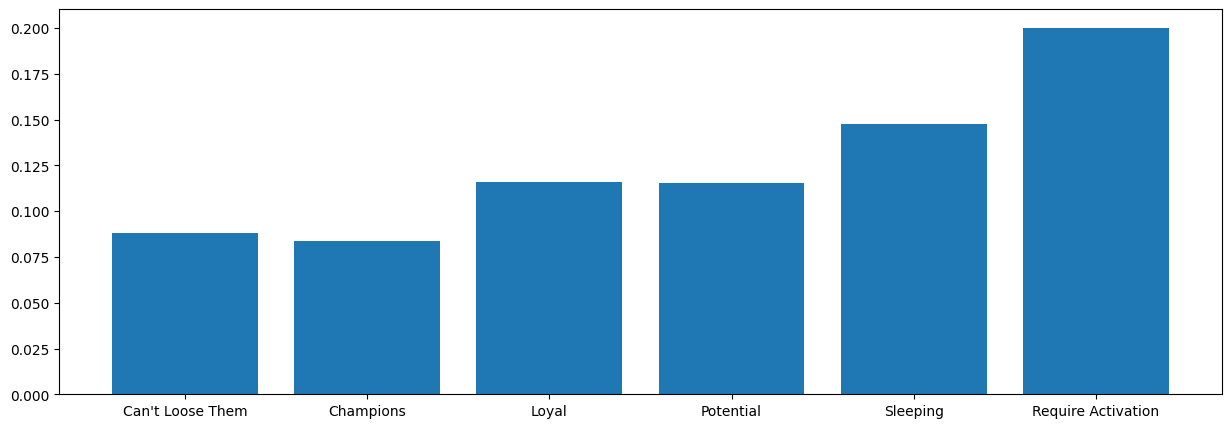

In [27]:
plt.figure(figsize=(15,5))
plt.bar(rfm_levels, NDCGs);

In [68]:
import random
from tqdm import tqdm

def evaluate(self, dataset):
    """
    Evaluation on the test users (users with at least 3 items)
    """
    usernum = dataset.usernum
    itemnum = dataset.itemnum
    train = dataset.user_train
    valid = dataset.user_valid
    test = dataset.user_test

    NDCG = 0.0
    HT = 0.0
    valid_user = 0.0

    if usernum > 10000:
        users = random.sample(range(1, usernum + 1), 10000)
    else:
        users = range(1, usernum + 1)

    for u in tqdm(users, ncols=70, leave=False, unit="b"):

        if len(train[u]) < 1 or len(test[u]) < 1:
            continue

        seq = np.zeros([self.seq_max_len], dtype=np.int32)
        idx = self.seq_max_len - 1
        seq[idx] = valid[u][0]
        idx -= 1
        for i in reversed(train[u]):
            seq[idx] = i
            idx -= 1
            if idx == -1:
                break
        rated = set(train[u])
        rated.add(0)
        item_idx = [random.choice(test[u])]
        # a positive example vs 100 negative examples.
        for _ in range(self.num_neg_test):
            t = np.random.randint(1, itemnum + 1)
            while t in rated or t in test[u]:
                t = np.random.randint(1, itemnum + 1)
            item_idx.append(t)

        inputs = {}
        inputs["user"] = np.expand_dims(np.array([u]), axis=-1)
        inputs["input_seq"] = np.array([seq])
        inputs["candidate"] = np.array([item_idx])

        # inverse to get descending sort
        predictions = -1.0 * self.predict(inputs)
        predictions = np.array(predictions)
        predictions = predictions[0]

        # we are interested only the first one, which is the only positive one
        rank = predictions.argsort().argsort()[0]

        valid_user += 1

        if rank < 5:
            NDCG += 1 / np.log2(rank + 2)
            HT += 1

    return NDCG / valid_user, HT / valid_user

In [69]:
evaluate(model, data)

(0.08496986637970463, 0.11699029126213592)

In [ ]:
def predict(self, dataset):
    usernum = dataset.usernum
    itemnum = dataset.itemnum
    train = dataset.user_train
    valid = dataset.user_valid
    test = dataset.user_test

    if usernum > 10000:
        users = random.sample(range(1, usernum + 1), 10000)
    else:
        users = range(1, usernum + 1)

    results = {}
    for u in tqdm(users, ncols=70, leave=False, unit="b"):
        # not enought training data
        if len(train[u]) < 1 or len(test[u]) < 1:
            continue

        # construct user purchase history
        seq = np.zeros([self.seq_max_len], dtype=np.int32)
        idx = self.seq_max_len - 1
        seq[idx] = valid[u][0]
        idx -= 1
        for i in reversed(train[u]):
            seq[idx] = i
            idx -= 1
            if idx == -1:
                break

            # already interacted items
            rated = set(train[u])

            item_idx = np.arange(itemnum)

            inputs = {}
            inputs["user"] = np.expand_dims(np.array([u]), axis=-1)
            inputs["input_seq"] = np.array([seq])
            inputs["candidate"] = np.array([item_idx])

            # inverse to get descending sort
            predictions = -1.0 * self.predict(inputs)
            predictions = np.array(predictions)
            predictions = predictions[0]

            results[u] = {'predictions': predictions, 'test': test[u]}

    return results